# House price predicting Notebook

This is a open dataset that I downloaded from the web ,it's the history data of house sales in King County , Seattle , USA, It includes homes sold between May 2014 and May 2015.The dataset is in CSV file format. Before doing anything we should first know about the dataset to get what it contains and the structure of data.

As described in the dataset introduction web page, the dataset contains 20 house features plus the price, along with 21613 observations.

- 1	 id 	 It is the unique numeric number assigned to each house being sold. 
- 2	 date 	 It is the date on which the house was sold out.  
- 3	 price	 It is the price of house which we have to predict so this is our target variable and apart from it are our features. 
- 4	 bedrooms 	 It determines number of bedrooms in a house. 
- 5	 bathrooms 	 It determines number of bathrooms in a bedroom of a house. 
- 6	 sqft_living 	 It is the measurement variable which determines the measurement of house in square foot. 
- 7	 sqft_lot 	 It is also the measurement variable which determines square foot of the lot. 
- 8	 floors	 It determines total floors means levels of house. 
- 9	 waterfront 	 This feature determines whether a house has a view to waterfront 0 means no 1 means yes. 
- 10	 view 	 This feature determines whether a house has been viewed or not 0 means no 1 means yes. 
- 11	 condition 	 It determines the overall condition of a house on a scale of 1 to 5. 
- 12	 grade 	 It determines the overall grade given to the housing unit, based on King County grading system on a scale of 1 to 11. 
- 13	 sqft_above 	 It determines square footage of house apart from basement. 
- 14	 sqft_basement 	 It determines square footage of the basement of the house. 
- 15	 yr_built 	 It determines the date of building of the house. 
- 16	 yr_renovated 	 It determines year of renovation of house. 
- 17	 zipcode 	 It determines the zipcode of the location of the house. 
- 18	 lat 	 It determines the latitude of the location of the house. 
- 19	 long 	 It determines the longitude of the location of the house. 
- 20	 sqft_living15 	 Living room area in 2015(implies-- some renovations) 
- 21	 sqft_lot15 	 lotSize area in 2015(implies-- some renovations) 

Main steps covered in this notebook:
- Lload the data file and then do some data cleaning and transformation.
- Proceed the EDA(Exploratory Data Analysis) process and finally select the features.
- Train some preditive models and evaluate them.

Let's get started.

### First , we import the libraries and setup some configuration parameters

In [203]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import pearsonr

import json # library to handle JSON files

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import explained_variance_score
import sklearn.learning_curve as curves
from time import time
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', 10000, 'display.max_rows', 10000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Setup Foursquare API credentials

In [204]:
CLIENT_ID = 'SOVAMTB52Q5GQPYY1VCI150OEQ3NRLRA5GL2BDPVKF4INVQ1' # your Foursquare ID
CLIENT_SECRET = 'DGCZWRARW2EWXIYIY2WM4JZAXG3P4YKCL1OZZRMBO0NISJ2P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SOVAMTB52Q5GQPYY1VCI150OEQ3NRLRA5GL2BDPVKF4INVQ1
CLIENT_SECRET:DGCZWRARW2EWXIYIY2WM4JZAXG3P4YKCL1OZZRMBO0NISJ2P


Load the dataset from the csv file and view sample data.

In [ ]:
df = pd.read_csv('kc_house_data.csv')
#df.describe()
#df.info()
df.head()

In [31]:
# check data size
df.shape

(21613, 21)

### Get Neighborhood Data with Foursquare API

Foursquare provides detailed location data , we can leverage it to explore the neighborhood that the house located, this might help to determine the house price. Since we have the zipcode and lat and long location in the house price dataset , it’s easy and straightforward to get neighborhood data through Foursquare API. <p>

As I have sandbox account for Foursquare API only which limits 950 regular calls/pay , and we have more than 20,000 records for this dataset,  I can not proceed with the API by one call per record for this dataset,  as a workaround , I use the latitude and longitude of average center of the zipcode to get the location data for each house.

First we group dataset by zipcode to compute the approximate latitude and longitude for a zipcode.

In [14]:
zipcode_data = df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace=True)

df['count'] = 1
count_houses_zipcode = df.groupby('zipcode').sum()
count_houses_zipcode.reset_index(inplace=True)
count_houses_zipcode = count_houses_zipcode[['zipcode','count']]
df.drop(['count'], axis = 1, inplace = True)

zipcode_data = pd.merge(zipcode_data, count_houses_zipcode, how='left', on=['zipcode'])
zipcode_data[['zipcode','lat','long']].head

,zipcode,lat,long
0,98001,47.309020,-122.270646
1,98002,47.308780,-122.213357
2,98003,47.315741,-122.310054
3,98004,47.616183,-122.205189
4,98005,47.611532,-122.167268
5,98006,47.558022,-122.146839
6,98007,47.610522,-122.142078
7,98008,47.613312,-122.115834
8,98010,47.333210,-121.999470
9,98011,47.755192,-122.201174


We define a function to get nearby venues of a location through Foursquare API.

In [15]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Fetch venues from Foursquare and check the result dataframe.

In [17]:
zipcode_venues = getNearbyVenues(names=zipcode_data['zipcode'],
                                   latitudes=zipcode_data['lat'],
                                   longitudes=zipcode_data['long']
                                  )

In [20]:
# zipcode_venues.to_csv('zipcode_venues.csv',index=None , header=True)
zipcode_venues.head()

,ZipCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,98001,47.309020,-122.270646,Centennial View Point Park,47.306903,-122.266138,Park
1,98002,47.308780,-122.213357,Athens Pizza and Pasta,47.308102,-122.216465,Italian Restaurant
2,98002,47.308780,-122.213357,Frank Fulmer Park,47.312361,-122.215185,Park
3,98003,47.315741,-122.310054,Trader Joe's,47.316795,-122.310927,Grocery Store
4,98003,47.315741,-122.310054,Grand Peking,47.316447,-122.311561,Chinese Restaurant


Group zipcode venues dataframe by zipcode to get the VenueCount of a zipcode.

In [24]:
df_zipcode_venues_count = zipcode_venues[['ZipCode','Venue']].groupby('ZipCode').count().reset_index().rename(columns={'Venue':'VenueCount'})
df_zipcode_venues_count.head()

,ZipCode,VenueCount
0,98001,1
1,98002,2
2,98003,100
3,98004,100
4,98005,4


Merge the zipcode venue dataframe back with the soure data frame, we get a new feature for each record : VenueCount, df2 is the new dataframe to process by the next steps. We also fill the NaN value with 0, which means that no venue found around the house.

In [41]:
df2=df.merge(df_zipcode_venues_count, how='left', left_on='zipcode',right_on='ZipCode').drop('ZipCode',axis=1).fillna(0)
df2.VenueCount = df2.VenueCount.astype('int')
# df2[pd.isna(df2['ZipCode'])]
print(df2.shape)
df2.head()

(21613, 22)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,VenueCount
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,6
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,29
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,10
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,1


In [42]:
# df2.to_csv('house_price_2.csv',header=True,index=None)

### Data Cleaning and Transformation:
- drop id column
- drop date column
- convert yr_built & yr_renovated to a more understandable meaning

Copy df2 to df3, we will do data cleaning and transformation to df3, df2 will be a backup dataframe at hand.

In [65]:
df3=df2.copy()
df3.shape

(21613, 22)

Use sales data minus yr_built and yu_renovated, we can get how old the house is.

In [66]:
# get the year of sales date
df3['yr_sales']=df3['date'].astype(str).str[:4]

# caculate the age of the house
df3['house_age']=df3['yr_sales'].astype(int)-df3['yr_built']
# caculate the renovate age of the house
df3['house_renew_age']=0
df3['house_renew_age']=df3['yr_sales'][df3['yr_renovated']!=0].astype(int)-df3['yr_renovated'][df3['yr_renovated']!=0]
df3['house_renew_age'][df3['house_renew_age'].isnull()]=0
df3['house_renew_age']=df3['house_renew_age'].astype(int)
df3['yr_sales']=df3['yr_sales'].astype(int)

In [67]:
df3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,VenueCount,yr_sales,house_age,house_renew_age
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,6,2014,59,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,13,2014,63,23
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,29,2015,82,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,10,2014,49,0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,1,2015,28,0


In [208]:
df3.drop(['id','date'], axis=1, inplace=True)

Show features related to house area.

In [209]:
df3[ [ c for c in df3.columns.to_list() if c.startswith('sqft') ] ].head(5)

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,1180,5650,1180,0,1340,5650
1,2570,7242,2170,400,1690,7639
2,770,10000,770,0,2720,8062
3,1960,5000,1050,910,1360,5000
4,1680,8080,1680,0,1800,7503


Show easy statistics for numeric features.

In [210]:
# df3.describe(include="all")
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.000,540088.142,367127.196,75000.000,321950.000,450000.000,645000.000,7700000.000
bedrooms,21613.000,3.371,0.930,0.000,3.000,3.000,4.000,33.000
bathrooms,21613.000,2.115,0.770,0.000,1.750,2.250,2.500,8.000
sqft_living,21613.000,2079.900,918.441,290.000,1427.000,1910.000,2550.000,13540.000
sqft_lot,21613.000,15106.968,41420.512,520.000,5040.000,7618.000,10688.000,1651359.000
floors,21613.000,1.494,0.540,1.000,1.000,1.500,2.000,3.500
waterfront,21613.000,0.008,0.087,0.000,0.000,0.000,0.000,1.000
view,21613.000,0.234,0.766,0.000,0.000,0.000,0.000,4.000
condition,21613.000,3.409,0.651,1.000,3.000,3.000,4.000,5.000
grade,21613.000,7.657,1.175,1.000,7.000,7.000,8.000,13.000


Plot histogram for features.

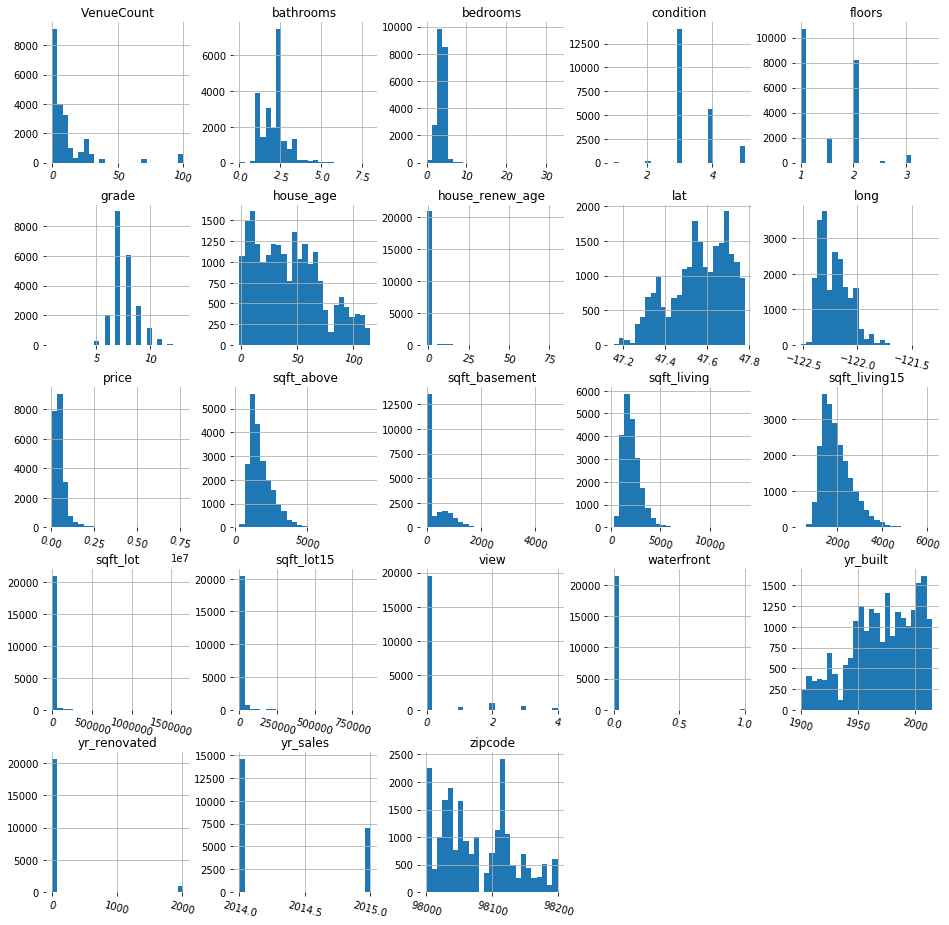

In [211]:
h = df3.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

### Correlations with target value computation 

In [78]:
features_all = df3.iloc[:,3:].columns.tolist()
target = df3.iloc[:,2].name

print(features_all)
print(target)

#calculate correlation of price with other variables
correlations = {}
for f in features_all:
    df_t = df3[[f,target]]
    x1 = df_t[f].values
    x2 = df_t[target].values
    key = f + ' - ' + target
    correlations[key] = pearsonr(x1,x2)[0]

df_correlations = pd.DataFrame(correlations, index=['Value']).T
df_correlations.loc[df_correlations['Value'].abs().sort_values(ascending=False).index]

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'VenueCount', 'yr_sales', 'house_age', 'house_renew_age']
price


,Value
sqft_living - price,0.702035
grade - price,0.667434
sqft_above - price,0.605567
sqft_living15 - price,0.585379
bathrooms - price,0.525138
view - price,0.397293
sqft_basement - price,0.323816
bedrooms - price,0.308350
lat - price,0.307003
waterfront - price,0.266369


Let's plot a heamap to visualize  the correlation matrix.

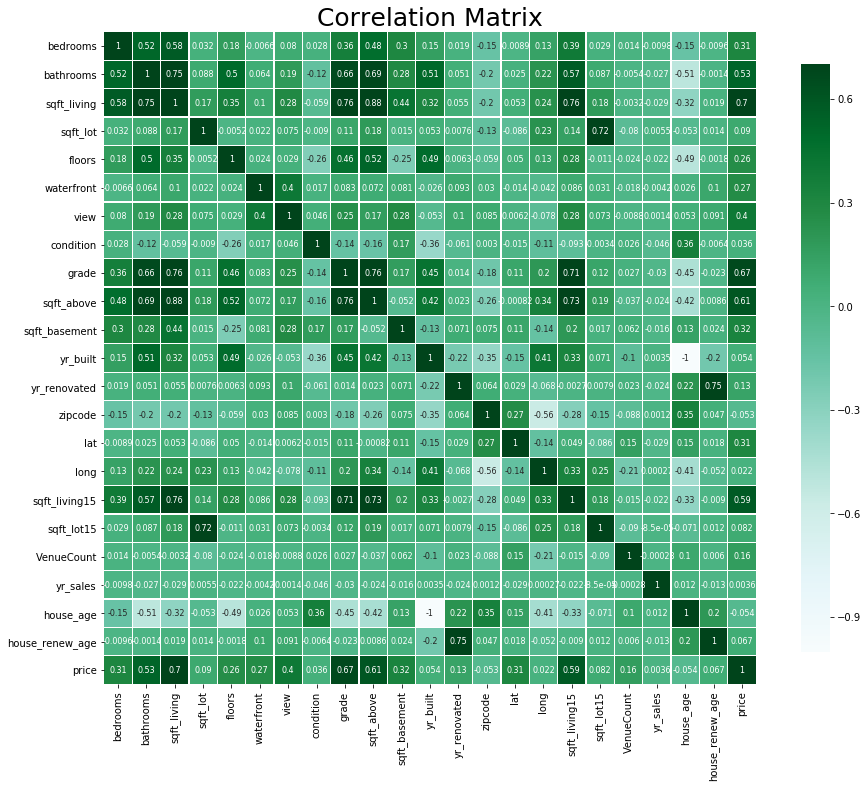

In [80]:
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation Matrix',fontsize=25)

sns.heatmap(df3[features_all+[target]].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", 
            linecolor='w',annot=True,annot_kws={"size":8},cbar_kws={"shrink": .9});

### Continuous data distribution and relationship with target value Visualization

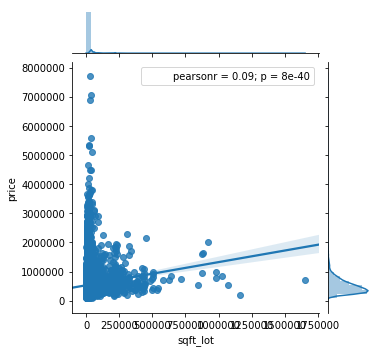

In [215]:
sns.jointplot(x="sqft_lot", y="price", data=df3, kind = 'reg', size = 5)

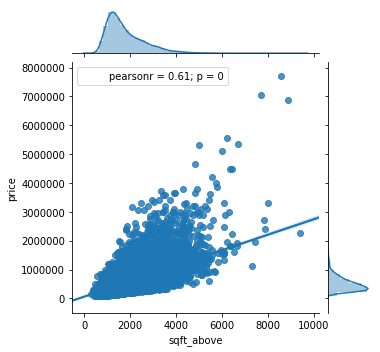

In [216]:
sns.jointplot(x="sqft_above", y="price", data=df3, kind = 'reg', size = 5)

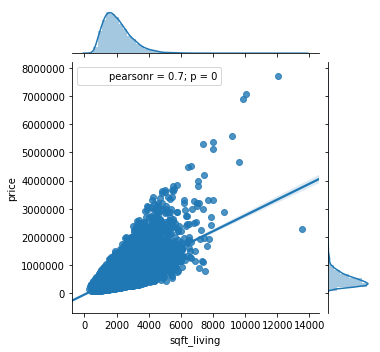

In [217]:
sns.jointplot(x="sqft_living", y="price", data=df3, kind = 'reg', size = 5)

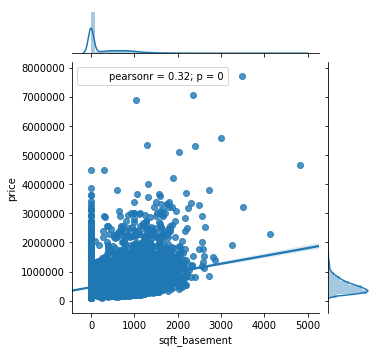

In [218]:
sns.jointplot(x="sqft_basement", y="price", data=df3, kind = 'reg', size = 5)

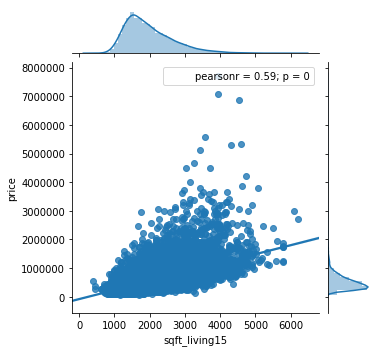

In [219]:
sns.jointplot(x="sqft_living15", y="price", data=df3, kind = 'reg', size = 5)

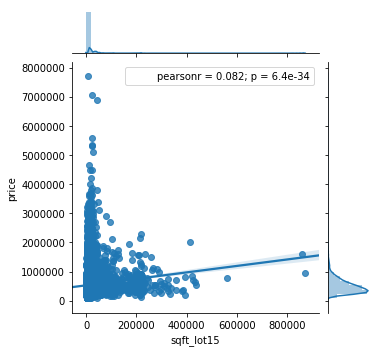

In [220]:
sns.jointplot(x="sqft_lot15", y="price", data=df3, kind = 'reg', size = 5)

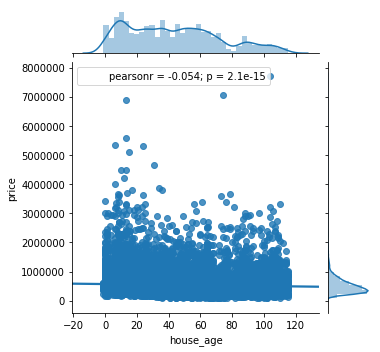

In [221]:
sns.jointplot(x="house_age", y="price", data=df3, kind = 'reg', size = 5)

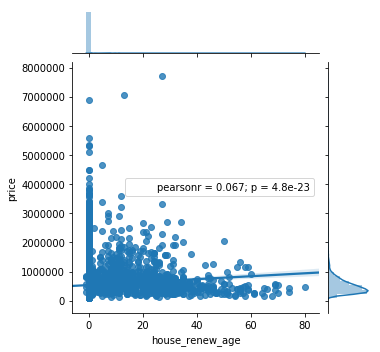

In [222]:
sns.jointplot(x="house_renew_age", y="price", data=df3, kind = 'reg', size = 5)

In [214]:
# sns.jointplot(x="sqft_lot", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="sqft_above", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="sqft_living", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="sqft_basement", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="sqft_living15", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="sqft_lot15", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="house_age", y="price", data=df3, kind = 'reg', size = 5)
# sns.jointplot(x="house_renew_age", y="price", data=df3, kind = 'reg', size = 5)

### Category data distribution and relationship with target value Visualization

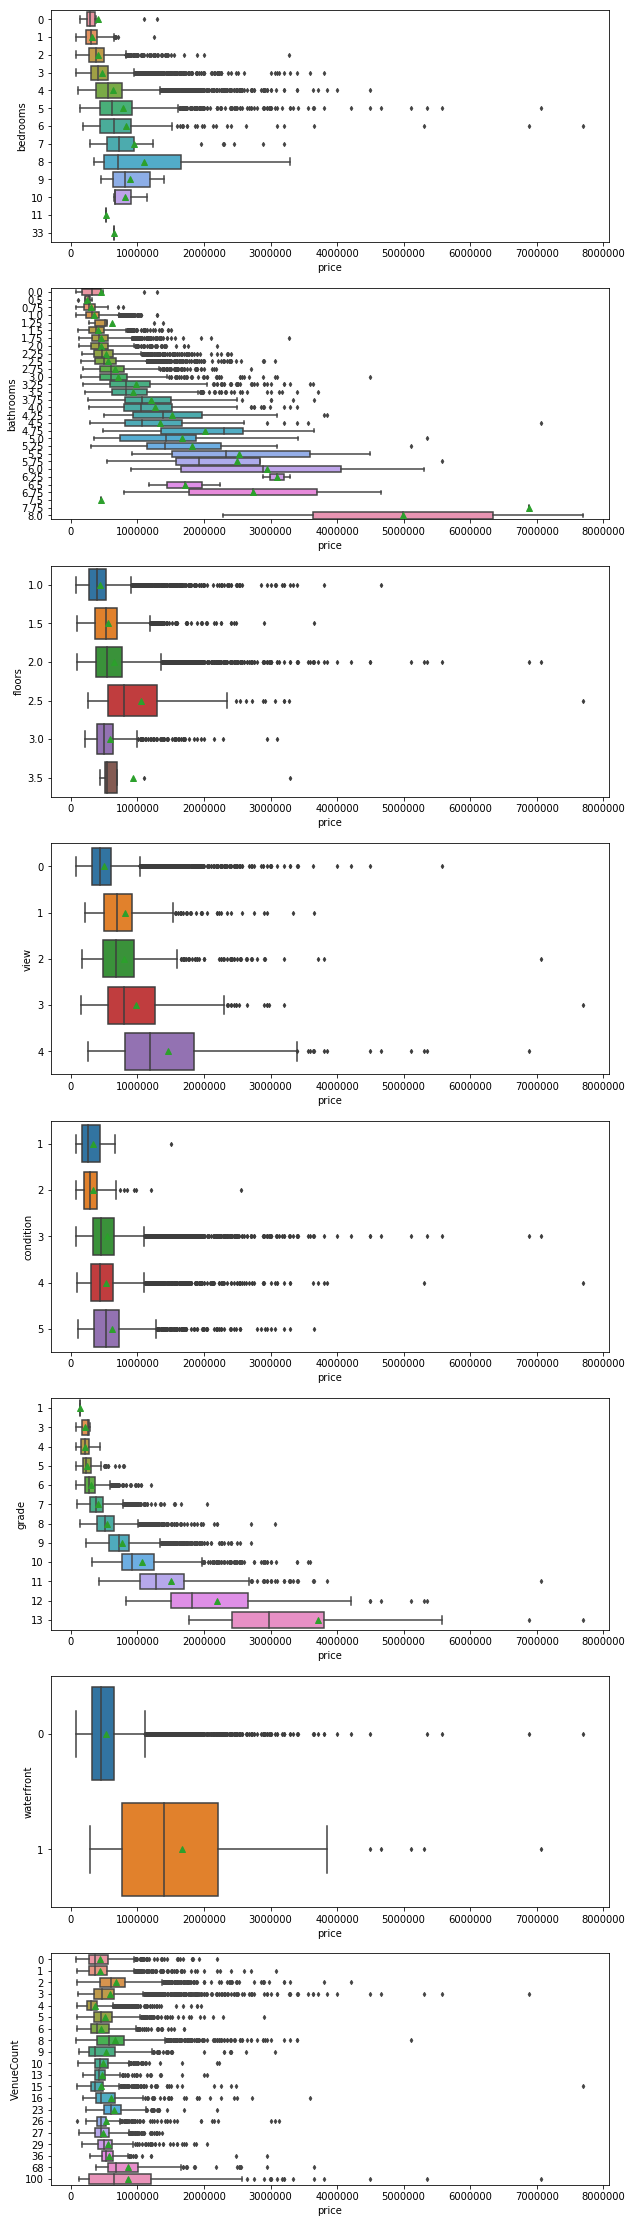

In [186]:
fig, axarr = plt.subplots(8,figsize=(10,40))
sns.boxplot(y = 'bedrooms', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax=axarr[0])
sns.boxplot(y = 'bathrooms', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[1])
sns.boxplot(y = 'floors', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[2])
sns.boxplot(y = 'view', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[3])
sns.boxplot(y = 'condition', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[4])
sns.boxplot(y = 'grade', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[5])
sns.boxplot(y = 'waterfront', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[6])
sns.boxplot(y = 'VenueCount', x = 'price', data = df3,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr[7])


Based on the EDA above, we can identify the features that have moderate/strong connection with the target variable , let's select the features to train the model as below:

In [131]:
feature_selection1 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','VenueCount','bedrooms','house_age']
# feature_selection1 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','VenueCount','bedrooms','house_age']
feature_selection2 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','bedrooms','zipcode']
# feature_selection2 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']

### Predictive Modeling
We are building a predictive model to predict house price, which is a continuous value ,so I used some regression algorithm to build the model.
AdaBoostRegressor, RandomForestRegressor and GradientBoostingRegressor were used to fit the model. As usual, I split the dataset into 2 parts, the training dataset and test dataset , these 2 datasets are similar, I fit the model on the training dataset, and test the model with the test dataset. As the fitted model doesn’t see the test dataset before, if it provides a good prediction on the test dataset,we have more confidence it will work on the new data to predict. That’s the way we are trying to avoid overfitting.
In this case, I am splitting dataset into 20% of test data and remaining 80% will used for training the model.
I used R2-score , Accuracy Score and Explained Variance Score to evaluate model performance, the training time and performance score are listed as below, Gradient Boosting Regressor got the best performance.

Split the dataset to get the train dataset and the test dataset .

In [192]:
X = df3[feature_selection2].values
y = df3.price.values

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

### Train and evaluate AdaBoostRegressor Model.

In [194]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

time_start = time()
model_ada = AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
time_end = time()
train_time_ada = time_end-time_start
score_ada = model_ada.score(X_test,y_test)
predict_result_ada = model_ada.predict(X_test)
r2_score_ada = r2_score(predict_result_ada,y_test)
exp_ada = explained_variance_score(predict_result_ada ,y_test)
print("{},{},{}".format(score_ada,r2_score_ada,exp_ada))

0.5252662298625818,0.3794522924675632,0.401186924982903


### Train and evaluate GradientBoostingRegressor Model.

In [197]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

time_start = time()
model_gbr = GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(X_train, y_train)
time_end = time()
train_time_gbr = time_end-time_start
score_gbr = model_gbr.score(X_test,y_test)
predict_result_gbr = model_gbr.predict(X_test)
r2_score_gbr = r2_score(predict_result_gbr,y_test)
exp_gbr = explained_variance_score(predict_result_gbr ,y_test)

print("{},{},{}".format(score_gbr,r2_score_gbr,exp_gbr))

0.820095193157115,0.8043963428069412,0.804409105331


### Train and evaluate RandomForestRegressor Model.

In [198]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

time_start = time()
model_rfr = RandomForestRegressor(n_estimators=400,random_state=0).fit(X_train, y_train)
time_end = time()
train_time_rfr = time_end-time_start
score_rfr = model_rfr.score(X_test,y_test)
predict_result_rfr = model_rfr.predict(X_test)
r2_score_rfr = r2_score(predict_result_rfr,y_test)
exp_rfr = explained_variance_score(predict_result_rfr ,y_test)

print("{},{},{}".format(score_rfr,r2_score_rfr,exp_rfr))

0.7800248885273562,0.7462115143980087,0.7462170947752021


### Model performance results.

In [200]:
models_eval_matrix = pd.DataFrame({
    'Model': ['AdaBoost','Random Forest','Gradient Boosting'],
    'Accuracy Score': [score_ada,score_rfr,score_gbr],
     'Variance Score': [exp_ada,exp_rfr,exp_gbr],
    'R2 Score':[r2_score_ada,r2_score_rfr,r2_score_gbr]})
    
models_eval_matrix.sort_values(by='Accuracy Score')

,Model,Accuracy Score,Variance Score,R2 Score
0,AdaBoost,0.525,0.401,0.379
1,Random Forest,0.780,0.746,0.746
2,Gradient Boosting,0.820,0.804,0.804


Model training time were logged , Random Forest took the most time.

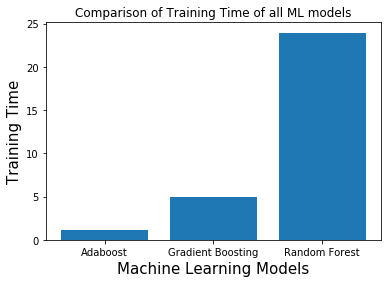

In [201]:
model = ['Adaboost', 'Gradient Boosting', 'Random Forest']
Train_Time = [
    train_time_ada,
    train_time_gbr,
    train_time_rfr,
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Training Time of all ML models')
plt.show()

### Conclusion

In this notebook, I described and explained how we can use data science to help predict a the sale price of a house. I analyzed the relationship between the house price and the independent variables in our dataset.I identified sqft_living, grade, view, bathrooms , bedrooms among the most important features that affect a house’s sale price. 
I built three regression models to predict the house price. A house buyer can use this model to select house with competitive price , a house seller or agent can use this mode to evaluate house price, which can be very useful in helping house sales or real estate market. 